In [1]:
import pandas as pd
import numpy as np

import numpy as np
from sklearn.model_selection import train_test_split, KFold
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

<Axes: ylabel='Frequency'>

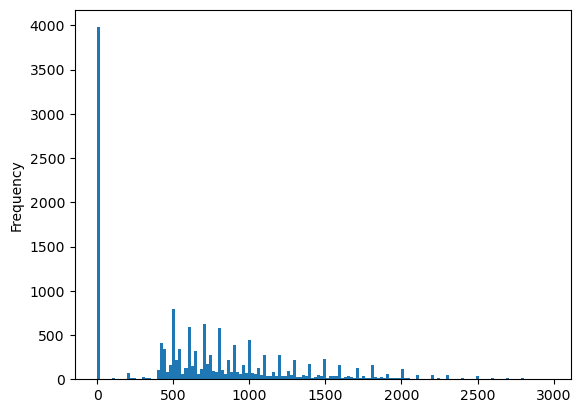

In [167]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
train = train[train['Age'] > 14]
train = train[train['Employment_Status'] != 'Not Working']
train = train[train['Industry_Status'] != 'Not in universe or children']
train[train['Income'] < 3000]['Income'].plot.hist(bins=150)

In [6]:
# train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
# test = pd.read_csv('./open/test.csv').drop('ID',axis=1)

# for column in tqdm(train.columns):
#     if train[column].dtype == 'object' and train[column].nunique() <= 4:  # 가짓수가 4 이상인 경우
#         encoded = pd.get_dummies(train[column], prefix=column)
#         train = pd.concat([train.drop(column, axis=1), encoded], axis=1)

# train

100%|█████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 162.50it/s]


,Age,Gender,Working_Week (Yearly),Gains,Losses,Dividends,Income_Status,Income,Education_Status_Associates degree (Academic),Education_Status_Associates degree (Vocational),...,Birth_Country (Mother)_US,Birth_Country (Mother)_Unknown,Birth_Country (Mother)_Vietnam,Birth_Country (Mother)_Yugoslavia,Tax_Status_Head of Household (HOH),Tax_Status_Married Filling Jointly both over 65 (MFJ),Tax_Status_Married Filling Jointly both under 65 (MFJ),Tax_Status_Married Filling Jointly one over 65 & one under 65 (MFJ),Tax_Status_Nonfiler,Tax_Status_Single
0,63,M,4,0,0,0,Unknown,425,0,0,...,1,0,0,0,0,0,0,0,1,0
1,37,M,52,0,0,0,Under Median,0,0,1,...,1,0,0,0,0,0,0,0,0,1
2,58,F,52,3411,0,0,Under Median,860,0,0,...,1,0,0,0,0,0,1,0,0,0
3,44,M,52,0,0,0,Under Median,850,0,0,...,1,0,0,0,0,0,0,0,0,1
4,37,F,52,0,0,0,Unknown,570,0,0,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,33,M,52,0,0,0,Under Median,1300,0,0,...,1,0,0,0,0,0,0,0,0,1
19996,20,F,12,0,0,0,Under Median,850,0,0,...,0,0,0,0,0,0,0,0,1,0
19997,22,M,52,0,0,0,Unknown,999,0,0,...,1,0,0,0,0,0,0,0,0,1
19998,76,F,0,0,0,0,Under Median,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [382]:
from pycaret.regression import *

train = pd.read_csv('./open/train.csv')
test = pd.read_csv('./open/test.csv')

# object_columns = train.select_dtypes(include=['object']).columns
# for i in object_columns:
#     train[i] = train[i].astype('category')
#     test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Income'] > 0)]
data = data.drop('ID',axis=1)
# PyCaret 회귀 모델 설정
regression_setup = setup(data, target='Income',
                         max_encoding_ohe=2,
                         train_size=0.8,
                         fold=10,
                         session_id=42)

# 다양한 회귀 모델 비교
best_model = compare_models(n_select=3, sort='RMSE')

,Description,Value
0,Session id,42
1,Target,Income
2,Target type,Regression
3,Original data shape,"(11145, 22)"
4,Transformed data shape,"(11145, 22)"
5,Transformed train set shape,"(8916, 22)"
6,Transformed test set shape,"(2229, 22)"
7,Ordinal features,1
8,Numeric features,5
9,Categorical features,16


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,245.3501,116540.8445,341.1393,0.4830,0.3453,0.3015,0.1380
gbr,Gradient Boosting Regressor,247.8585,116648.9367,341.2743,0.4825,0.3484,0.3070,0.3120
catboost,CatBoost Regressor,246.1275,117163.0712,342.0395,0.4803,0.3463,0.3018,1.1970
rf,Random Forest Regressor,255.7584,124433.9414,352.4927,0.4478,0.3581,0.3171,0.7710
xgboost,Extreme Gradient Boosting,254.6904,124953.4822,353.2407,0.4457,0.3581,0.3118,0.3330
lr,Linear Regression,269.2051,128653.5888,358.3658,0.4295,0.3818,0.3395,0.6470
ridge,Ridge Regression,269.2051,128653.6226,358.3658,0.4295,0.3818,0.3395,0.1050
lasso,Lasso Regression,269.2111,128660.6103,358.3749,0.4295,0.3816,0.3395,0.1070
llar,Lasso Least Angle Regression,269.2111,128660.6274,358.3749,0.4295,0.3816,0.3395,0.0990
lar,Least Angle Regression,269.2638,128685.2041,358.4103,0.4294,0.3820,0.3396,0.1000


In [127]:
train.columns

Index(['Age', 'Gender', 'Education_Status', 'Employment_Status',
       'Working_Week (Yearly)', 'Industry_Status', 'Occupation_Status', 'Race',
       'Hispanic_Origin', 'Martial_Status', 'Household_Status',
       'Household_Summary', 'Citizenship', 'Birth_Country',
       'Birth_Country (Father)', 'Birth_Country (Mother)', 'Tax_Status',
       'Gains', 'Losses', 'Dividends', 'Income_Status', 'Income'],
      dtype='object')

In [ ]:
# feaature engineering

In [191]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Employment_Status'] != 'Not Working') & ((train['Industry_Status'] != 'Not in universe or children'))]
X = data.drop('Income',axis=1)
y = data[['Income']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4242)

def objective(trial):
    # 하이퍼파라미터 검색 범위 지정
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }
    
    # 교차 검증 설정 (5-Fold 교차 검증 사용)
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    rmse_scores = []

    for train_index, valid_index in kf.split(X_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[valid_index]
        y_tr, y_val = y_train.iloc[train_index], y_train.iloc[valid_index]

        # LightGBM 모델 정의
        model = lgb.LGBMRegressor(**params)

        # 모델 훈련
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=100, verbose=False)

        # 검증 데이터로 RMSE 계산
        y_pred = model.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_scores.append(rmse)

    # 교차 검증 평균 RMSE 반환
    return np.mean(rmse_scores)

# Optuna 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-03-21 21:24:41,565] A new study created in memory with name: no-name-3b421298-0397-47e9-9c67-fd1f04dff89c
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/r

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7376790418161371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7376790418161371
[LightGBM] [Warning] bagging_fraction is set=0.684746516525194, subsample=1.0 will be ignored. Current value: bagging_fraction=0.684746516525194
[LightGBM] [Warning] lambda_l1 is set=0.0001305164874457583, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001305164874457583
[LightGBM] [Warning] lambda_l2 is set=0.2151079542994167, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2151079542994167
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:24:53,502] Trial 0 finished with value: 584.7593804953019 and parameters: {'lambda_l1': 0.0001305164874457583, 'lambda_l2': 0.2151079542994167, 'num_leaves': 48, 'learning_rate': 1.696149898615012e-05, 'feature_fraction': 0.7376790418161371, 'bagging_fraction': 0.684746516525194, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 0 with value: 584.7593804953019.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7077414612801414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7077414612801414
[LightGBM] [Warning] bagging_fraction is set=0.6215272263506421, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6215272263506421
[LightGBM] [Warning] lambda_l1 is set=1.302632347518535e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.302632347518535e-06
[LightGBM] [Warning] lambda_l2 is set=1.4843381687921197e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4843381687921197e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-03-21 21:25:27,694] Trial 1 finished with value: 583.3701000192771 and parameters: {'lambda_l1': 1.302632347518535e-06, 'lambda_l2': 1.4843381687921197e-05, 'num_leaves': 215, 'learning_rate': 0.00017821944568274445, 'feature_fraction': 0.7077414612801414, 'bagging_fraction': 0.6215272263506421, 'bagging_freq': 7, 'min_child_samples': 10}. Best is trial 1 with value: 583.3701000192771.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8695271283922756, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8695271283922756
[LightGBM] [Warning] bagging_fraction is set=0.5391658182157653, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5391658182157653
[LightGBM] [Warning] lambda_l1 is set=1.142044057617485e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.142044057617485e-07
[LightGBM] [Warning] lambda_l2 is set=0.032929624018625, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032929624018625
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-21 21:25:35,189] Trial 2 finished with value: 584.9080176511586 and parameters: {'lambda_l1': 1.142044057617485e-07, 'lambda_l2': 0.032929624018625, 'num_leaves': 30, 'learning_rate': 1.5895758613168068e-08, 'feature_fraction': 0.8695271283922756, 'bagging_fraction': 0.5391658182157653, 'bagging_freq': 4, 'min_child_samples': 65}. Best is trial 1 with value: 583.3701000192771.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9493997800218382, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9493997800218382
[LightGBM] [Warning] bagging_fraction is set=0.8029089969292856, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8029089969292856
[LightGBM] [Warning] lambda_l1 is set=1.3844072168048614e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3844072168048614e-07
[LightGBM] [Warning] lambda_l2 is set=2.399694203930922e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.399694203930922e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2024-03-21 21:25:47,539] Trial 3 finished with value: 584.9079970679328 and parameters: {'lambda_l1': 1.3844072168048614e-07, 'lambda_l2': 2.399694203930922e-07, 'num_leaves': 185, 'learning_rate': 1.6427963638877345e-08, 'feature_fraction': 0.9493997800218382, 'bagging_fraction': 0.8029089969292856, 'bagging_freq': 7, 'min_child_samples': 51}. Best is trial 1 with value: 583.3701000192771.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.42261977535047435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42261977535047435
[LightGBM] [Warning] bagging_fraction is set=0.6292299618889824, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6292299618889824
[LightGBM] [Warning] lambda_l1 is set=1.282779123241164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.282779123241164
[LightGBM] [Warning] lambda_l2 is set=0.01105202593907695, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01105202593907695
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:25:52,309] Trial 4 finished with value: 537.2006929872585 and parameters: {'lambda_l1': 1.282779123241164, 'lambda_l2': 0.01105202593907695, 'num_leaves': 120, 'learning_rate': 0.8291859587228018, 'feature_fraction': 0.42261977535047435, 'bagging_fraction': 0.6292299618889824, 'bagging_freq': 3, 'min_child_samples': 61}. Best is trial 4 with value: 537.2006929872585.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  '

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.503571200093963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.503571200093963
[LightGBM] [Warning] bagging_fraction is set=0.44946259096301766, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44946259096301766
[LightGBM] [Warning] lambda_l1 is set=0.00021313663604784997, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021313663604784997
[LightGBM] [Warning] lambda_l2 is set=8.754458053514323e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.754458053514323e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-21 21:25:55,967] Trial 5 finished with value: 584.8517378319908 and parameters: {'lambda_l1': 0.00021313663604784997, 'lambda_l2': 8.754458053514323e-07, 'num_leaves': 252, 'learning_rate': 8.324001576188822e-06, 'feature_fraction': 0.503571200093963, 'bagging_fraction': 0.44946259096301766, 'bagging_freq': 1, 'min_child_samples': 86}. Best is trial 4 with value: 537.2006929872585.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7211888174378143, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7211888174378143
[LightGBM] [Warning] bagging_fraction is set=0.5949562901444757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949562901444757
[LightGBM] [Warning] lambda_l1 is set=6.30976224834375, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.30976224834375
[LightGBM] [Warning] lambda_l2 is set=0.01165433982106891, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01165433982106891
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-21 21:26:00,010] Trial 6 finished with value: 584.9059815135486 and parameters: {'lambda_l1': 6.30976224834375, 'lambda_l2': 0.01165433982106891, 'num_leaves': 51, 'learning_rate': 2.604463284817407e-07, 'feature_fraction': 0.7211888174378143, 'bagging_fraction': 0.5949562901444757, 'bagging_freq': 1, 'min_child_samples': 70}. Best is trial 4 with value: 537.2006929872585.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  '

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7831175221600342, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7831175221600342
[LightGBM] [Warning] bagging_fraction is set=0.8203123623397475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8203123623397475
[LightGBM] [Warning] lambda_l1 is set=1.330267137487826e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.330267137487826e-05
[LightGBM] [Warning] lambda_l2 is set=1.713532872358364e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.713532872358364e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:26:04,695] Trial 7 finished with value: 584.899908641957 and parameters: {'lambda_l1': 1.330267137487826e-05, 'lambda_l2': 1.713532872358364e-05, 'num_leaves': 239, 'learning_rate': 9.266269454981606e-07, 'feature_fraction': 0.7831175221600342, 'bagging_fraction': 0.8203123623397475, 'bagging_freq': 3, 'min_child_samples': 86}. Best is trial 4 with value: 537.2006929872585.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5896195763392128, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5896195763392128
[LightGBM] [Warning] bagging_fraction is set=0.9852315488601144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9852315488601144
[LightGBM] [Warning] lambda_l1 is set=1.9757156795959463e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9757156795959463e-06
[LightGBM] [Warning] lambda_l2 is set=1.0588789565698957e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0588789565698957e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-21 21:26:10,296] Trial 8 finished with value: 549.9278371991138 and parameters: {'lambda_l1': 1.9757156795959463e-06, 'lambda_l2': 1.0588789565698957e-06, 'num_leaves': 240, 'learning_rate': 0.006439384024103751, 'feature_fraction': 0.5896195763392128, 'bagging_fraction': 0.9852315488601144, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 4 with value: 537.2006929872585.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6603785890996545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6603785890996545
[LightGBM] [Warning] bagging_fraction is set=0.7257751949903092, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7257751949903092
[LightGBM] [Warning] lambda_l1 is set=6.65354749610855e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.65354749610855e-08
[LightGBM] [Warning] lambda_l2 is set=7.088539597035988e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.088539597035988e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-21 21:26:14,062] Trial 9 finished with value: 584.9078247945091 and parameters: {'lambda_l1': 6.65354749610855e-08, 'lambda_l2': 7.088539597035988e-05, 'num_leaves': 91, 'learning_rate': 4.103260982342925e-08, 'feature_fraction': 0.6603785890996545, 'bagging_fraction': 0.7257751949903092, 'bagging_freq': 1, 'min_child_samples': 88}. Best is trial 4 with value: 537.2006929872585.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.40149752213478423, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40149752213478423
[LightGBM] [Warning] bagging_fraction is set=0.4072595288633345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4072595288633345
[LightGBM] [Warning] lambda_l1 is set=0.3782212606217836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3782212606217836
[LightGBM] [Warning] lambda_l2 is set=0.0015226940369825854, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015226940369825854
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-21 21:26:18,726] Trial 10 finished with value: 543.629893183372 and parameters: {'lambda_l1': 0.3782212606217836, 'lambda_l2': 0.0015226940369825854, 'num_leaves': 144, 'learning_rate': 0.7723853612914154, 'feature_fraction': 0.40149752213478423, 'bagging_fraction': 0.4072595288633345, 'bagging_freq': 5, 'min_child_samples': 25}. Best is trial 4 with value: 537.2006929872585.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4097973489278716, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4097973489278716
[LightGBM] [Warning] bagging_fraction is set=0.4004385259210945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4004385259210945
[LightGBM] [Warning] lambda_l1 is set=0.41344819420273443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.41344819420273443
[LightGBM] [Warning] lambda_l2 is set=0.0015875033452368754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015875033452368754
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-21 21:26:23,199] Trial 11 finished with value: 542.1366555114616 and parameters: {'lambda_l1': 0.41344819420273443, 'lambda_l2': 0.0015875033452368754, 'num_leaves': 139, 'learning_rate': 0.7133408957430197, 'feature_fraction': 0.4097973489278716, 'bagging_fraction': 0.4004385259210945, 'bagging_freq': 5, 'min_child_samples': 27}. Best is trial 4 with value: 537.2006929872585.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4033153223912876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4033153223912876
[LightGBM] [Warning] bagging_fraction is set=0.493731931139785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.493731931139785
[LightGBM] [Warning] lambda_l1 is set=0.032068836125493556, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.032068836125493556
[LightGBM] [Warning] lambda_l2 is set=8.186298783187246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.186298783187246
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-21 21:26:27,766] Trial 12 finished with value: 529.632098710714 and parameters: {'lambda_l1': 0.032068836125493556, 'lambda_l2': 8.186298783187246, 'num_leaves': 127, 'learning_rate': 0.3276154489247954, 'feature_fraction': 0.4033153223912876, 'bagging_fraction': 0.493731931139785, 'bagging_freq': 5, 'min_child_samples': 34}. Best is trial 12 with value: 529.632098710714.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5166005304063234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5166005304063234
[LightGBM] [Warning] bagging_fraction is set=0.5152549022352461, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5152549022352461
[LightGBM] [Warning] lambda_l1 is set=0.01257974843419205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01257974843419205
[LightGBM] [Warning] lambda_l2 is set=5.794074996770559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.794074996770559
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-21 21:26:32,669] Trial 13 finished with value: 529.6220011702904 and parameters: {'lambda_l1': 0.01257974843419205, 'lambda_l2': 5.794074996770559, 'num_leaves': 93, 'learning_rate': 0.022765620159088226, 'feature_fraction': 0.5166005304063234, 'bagging_fraction': 0.5152549022352461, 'bagging_freq': 5, 'min_child_samples': 37}. Best is trial 13 with value: 529.6220011702904.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5449037637876656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5449037637876656
[LightGBM] [Warning] bagging_fraction is set=0.5096431995629137, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5096431995629137
[LightGBM] [Warning] lambda_l1 is set=0.00822363241651105, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00822363241651105
[LightGBM] [Warning] lambda_l2 is set=4.653478488647794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.653478488647794
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-03-21 21:26:35,744] Trial 14 finished with value: 534.5612741757794 and parameters: {'lambda_l1': 0.00822363241651105, 'lambda_l2': 4.653478488647794, 'num_leaves': 98, 'learning_rate': 0.016538262704687626, 'feature_fraction': 0.5449037637876656, 'bagging_fraction': 0.5096431995629137, 'bagging_freq': 6, 'min_child_samples': 37}. Best is trial 13 with value: 529.6220011702904.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.49764338647933626, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49764338647933626
[LightGBM] [Warning] bagging_fraction is set=0.5015354283079188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5015354283079188
[LightGBM] [Warning] lambda_l1 is set=0.015596484273287123, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.015596484273287123
[LightGBM] [Warning] lambda_l2 is set=4.270424156849049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.270424156849049
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2024-03-21 21:26:40,164] Trial 15 finished with value: 536.0414600842915 and parameters: {'lambda_l1': 0.015596484273287123, 'lambda_l2': 4.270424156849049, 'num_leaves': 172, 'learning_rate': 0.01644099827690803, 'feature_fraction': 0.49764338647933626, 'bagging_fraction': 0.5015354283079188, 'bagging_freq': 5, 'min_child_samples': 7}. Best is trial 13 with value: 529.6220011702904.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6089372284057206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6089372284057206
[LightGBM] [Warning] bagging_fraction is set=0.5553015634459961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5553015634459961
[LightGBM] [Warning] lambda_l1 is set=0.012801705555497124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.012801705555497124
[LightGBM] [Warning] lambda_l2 is set=0.36362175581898737, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.36362175581898737
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2024-03-21 21:26:43,505] Trial 16 finished with value: 578.2290816944953 and parameters: {'lambda_l1': 0.012801705555497124, 'lambda_l2': 0.36362175581898737, 'num_leaves': 81, 'learning_rate': 0.0009182261995811157, 'feature_fraction': 0.6089372284057206, 'bagging_fraction': 0.5553015634459961, 'bagging_freq': 6, 'min_child_samples': 26}. Best is trial 13 with value: 529.6220011702904.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.48235143414247444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48235143414247444
[LightGBM] [Warning] bagging_fraction is set=0.47310463613845566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47310463613845566
[LightGBM] [Warning] lambda_l1 is set=0.0024322017969614935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0024322017969614935
[LightGBM] [Warning] lambda_l2 is set=6.944573277591137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.944573277591137
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-21 21:26:46,338] Trial 17 finished with value: 524.4008104894447 and parameters: {'lambda_l1': 0.0024322017969614935, 'lambda_l2': 6.944573277591137, 'num_leaves': 166, 'learning_rate': 0.08242259362810161, 'feature_fraction': 0.48235143414247444, 'bagging_fraction': 0.47310463613845566, 'bagging_freq': 4, 'min_child_samples': 39}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4908486112627914, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4908486112627914
[LightGBM] [Warning] bagging_fraction is set=0.7094469575264672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7094469575264672
[LightGBM] [Warning] lambda_l1 is set=0.001331826510991331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001331826510991331
[LightGBM] [Warning] lambda_l2 is set=0.41527738726038155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41527738726038155
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-21 21:26:51,071] Trial 18 finished with value: 525.2525217124455 and parameters: {'lambda_l1': 0.001331826510991331, 'lambda_l2': 0.41527738726038155, 'num_leaves': 179, 'learning_rate': 0.0660389754303923, 'feature_fraction': 0.4908486112627914, 'bagging_fraction': 0.7094469575264672, 'bagging_freq': 4, 'min_child_samples': 17}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6289543994816141, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6289543994816141
[LightGBM] [Warning] bagging_fraction is set=0.8192703301373346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8192703301373346
[LightGBM] [Warning] lambda_l1 is set=0.0014122268474485425, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014122268474485425
[LightGBM] [Warning] lambda_l2 is set=0.33127123930258745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33127123930258745
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-21 21:26:56,826] Trial 19 finished with value: 527.1300362804 and parameters: {'lambda_l1': 0.0014122268474485425, 'lambda_l2': 0.33127123930258745, 'num_leaves': 182, 'learning_rate': 0.09574788413456355, 'feature_fraction': 0.6289543994816141, 'bagging_fraction': 0.8192703301373346, 'bagging_freq': 4, 'min_child_samples': 12}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4762130262284066, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4762130262284066
[LightGBM] [Warning] bagging_fraction is set=0.9187296587566448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9187296587566448
[LightGBM] [Warning] lambda_l1 is set=4.177292268939121e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.177292268939121e-05
[LightGBM] [Warning] lambda_l2 is set=0.11454564636153994, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.11454564636153994
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-21 21:27:02,516] Trial 20 finished with value: 576.7201942080895 and parameters: {'lambda_l1': 4.177292268939121e-05, 'lambda_l2': 0.11454564636153994, 'num_leaves': 206, 'learning_rate': 0.0012394963626022662, 'feature_fraction': 0.4762130262284066, 'bagging_fraction': 0.9187296587566448, 'bagging_freq': 2, 'min_child_samples': 19}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6129073815830087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6129073815830087
[LightGBM] [Warning] bagging_fraction is set=0.7810021997341825, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7810021997341825
[LightGBM] [Warning] lambda_l1 is set=0.0015019507057378915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015019507057378915
[LightGBM] [Warning] lambda_l2 is set=1.423942564255116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.423942564255116e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-21 21:27:07,841] Trial 21 finished with value: 525.5674385030421 and parameters: {'lambda_l1': 0.0015019507057378915, 'lambda_l2': 1.423942564255116e-08, 'num_leaves': 169, 'learning_rate': 0.07993545850275492, 'feature_fraction': 0.6129073815830087, 'bagging_fraction': 0.7810021997341825, 'bagging_freq': 4, 'min_child_samples': 15}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5581336895944836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5581336895944836
[LightGBM] [Warning] bagging_fraction is set=0.7415814046880622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7415814046880622
[LightGBM] [Warning] lambda_l1 is set=0.001130647806812283, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001130647806812283
[LightGBM] [Warning] lambda_l2 is set=1.3497641870459153e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3497641870459153e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-21 21:27:12,710] Trial 22 finished with value: 524.987276415014 and parameters: {'lambda_l1': 0.001130647806812283, 'lambda_l2': 1.3497641870459153e-08, 'num_leaves': 155, 'learning_rate': 0.0957656553160008, 'feature_fraction': 0.5581336895944836, 'bagging_fraction': 0.7415814046880622, 'bagging_freq': 4, 'min_child_samples': 19}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5657987355829068, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5657987355829068
[LightGBM] [Warning] bagging_fraction is set=0.742792416452133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.742792416452133
[LightGBM] [Warning] lambda_l1 is set=0.0010322291285501735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010322291285501735
[LightGBM] [Warning] lambda_l2 is set=1.0357826912468843e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0357826912468843e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2024-03-21 21:27:17,646] Trial 23 finished with value: 569.7131132457985 and parameters: {'lambda_l1': 0.0010322291285501735, 'lambda_l2': 1.0357826912468843e-08, 'num_leaves': 153, 'learning_rate': 0.0021946011635897334, 'feature_fraction': 0.5657987355829068, 'bagging_fraction': 0.742792416452133, 'bagging_freq': 4, 'min_child_samples': 21}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4808017374056015, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4808017374056015
[LightGBM] [Warning] bagging_fraction is set=0.6790907036591372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6790907036591372
[LightGBM] [Warning] lambda_l1 is set=0.07798899775199557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07798899775199557
[LightGBM] [Warning] lambda_l2 is set=0.5935381378461501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5935381378461501
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:27:21,204] Trial 24 finished with value: 525.1440052567198 and parameters: {'lambda_l1': 0.07798899775199557, 'lambda_l2': 0.5935381378461501, 'num_leaves': 207, 'learning_rate': 0.11966739451910492, 'feature_fraction': 0.4808017374056015, 'bagging_fraction': 0.6790907036591372, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.


[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.46601360884744786, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46601360884744786
[LightGBM] [Warning] bagging_fraction is set=0.8967639897713224, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8967639897713224
[LightGBM] [Warning] lambda_l1 is set=0.14895793041988145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14895793041988145
[LightGBM] [Warning] lambda_l2 is set=0.00027113125488916764, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00027113125488916764
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-21 21:27:25,368] Trial 25 finished with value: 583.7350454979431 and parameters: {'lambda_l1': 0.14895793041988145, 'lambda_l2': 0.00027113125488916764, 'num_leaves': 209, 'learning_rate': 0.00016840020034586303, 'feature_fraction': 0.46601360884744786, 'bagging_fraction': 0.8967639897713224, 'bagging_freq': 2, 'min_child_samples': 50}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.5503698564551299, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5503698564551299
[LightGBM] [Warning] bagging_fraction is set=0.6499791372251342, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6499791372251342
[LightGBM] [Warning] lambda_l1 is set=0.07469828058865803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07469828058865803
[LightGBM] [Warning] lambda_l2 is set=1.176867190937639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.176867190937639
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-21 21:27:29,300] Trial 26 finished with value: 525.8477544871294 and parameters: {'lambda_l1': 0.07469828058865803, 'lambda_l2': 1.176867190937639, 'num_leaves': 199, 'learning_rate': 0.17485787540074088, 'feature_fraction': 0.5503698564551299, 'bagging_fraction': 0.6499791372251342, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
 

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.4521572313719847, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4521572313719847
[LightGBM] [Warning] bagging_fraction is set=0.8603746374774369, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8603746374774369
[LightGBM] [Warning] lambda_l1 is set=7.120663923641007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.120663923641007
[LightGBM] [Warning] lambda_l2 is set=0.03934548806353687, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03934548806353687
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:27:33,471] Trial 27 finished with value: 565.4389009007425 and parameters: {'lambda_l1': 7.120663923641007, 'lambda_l2': 0.03934548806353687, 'num_leaves': 158, 'learning_rate': 0.0033438579394844507, 'feature_fraction': 0.4521572313719847, 'bagging_fraction': 0.8603746374774369, 'bagging_freq': 3, 'min_child_samples': 45}. Best is trial 17 with value: 524.4008104894447.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6702105795922487, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6702105795922487
[LightGBM] [Warning] bagging_fraction is set=0.6736587947933708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6736587947933708
[LightGBM] [Warning] lambda_l1 is set=0.003428709180164653, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003428709180164653
[LightGBM] [Warning] lambda_l2 is set=1.0900489659542481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0900489659542481e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:27:37,274] Trial 28 finished with value: 524.0317604257989 and parameters: {'lambda_l1': 0.003428709180164653, 'lambda_l2': 1.0900489659542481e-07, 'num_leaves': 228, 'learning_rate': 0.029174816771565658, 'feature_fraction': 0.6702105795922487, 'bagging_fraction': 0.6736587947933708, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 28 with value: 524.0317604257989.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7885150484576169, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7885150484576169
[LightGBM] [Warning] bagging_fraction is set=0.7550306384678402, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7550306384678402
[LightGBM] [Warning] lambda_l1 is set=5.7093462731893266e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7093462731893266e-05
[LightGBM] [Warning] lambda_l2 is set=7.200950085486845e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.200950085486845e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-21 21:27:40,663] Trial 29 finished with value: 584.8183646028372 and parameters: {'lambda_l1': 5.7093462731893266e-05, 'lambda_l2': 7.200950085486845e-08, 'num_leaves': 227, 'learning_rate': 1.0102690978768765e-05, 'feature_fraction': 0.7885150484576169, 'bagging_fraction': 0.7550306384678402, 'bagging_freq': 2, 'min_child_samples': 75}. Best is trial 28 with value: 524.0317604257989.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) 

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6604602507793061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6604602507793061
[LightGBM] [Warning] bagging_fraction is set=0.5752545177256887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5752545177256887
[LightGBM] [Warning] lambda_l1 is set=0.00048279198314504204, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00048279198314504204
[LightGBM] [Warning] lambda_l2 is set=5.953451954181855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.953451954181855e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:27:43,521] Trial 30 finished with value: 580.2428156793179 and parameters: {'lambda_l1': 0.00048279198314504204, 'lambda_l2': 5.953451954181855e-08, 'num_leaves': 124, 'learning_rate': 0.0006044707682101899, 'feature_fraction': 0.6604602507793061, 'bagging_fraction': 0.5752545177256887, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 28 with value: 524.0317604257989.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) i

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6540336741484777, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6540336741484777
[LightGBM] [Warning] bagging_fraction is set=0.6744124407096388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6744124407096388
[LightGBM] [Warning] lambda_l1 is set=0.004222904737695153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004222904737695153
[LightGBM] [Warning] lambda_l2 is set=2.1276443470810875e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1276443470810875e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:27:46,584] Trial 31 finished with value: 522.569219058866 and parameters: {'lambda_l1': 0.004222904737695153, 'lambda_l2': 2.1276443470810875e-06, 'num_leaves': 193, 'learning_rate': 0.055811595730609585, 'feature_fraction': 0.6540336741484777, 'bagging_fraction': 0.6744124407096388, 'bagging_freq': 3, 'min_child_samples': 97}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6717899510163186, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6717899510163186
[LightGBM] [Warning] bagging_fraction is set=0.6691143449714466, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6691143449714466
[LightGBM] [Warning] lambda_l1 is set=0.003946978044887915, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003946978044887915
[LightGBM] [Warning] lambda_l2 is set=3.128920582574004e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.128920582574004e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:27:49,627] Trial 32 finished with value: 523.7223737177449 and parameters: {'lambda_l1': 0.003946978044887915, 'lambda_l2': 3.128920582574004e-06, 'num_leaves': 193, 'learning_rate': 0.03201009578147871, 'feature_fraction': 0.6717899510163186, 'bagging_fraction': 0.6691143449714466, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7726998683830235, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7726998683830235
[LightGBM] [Warning] bagging_fraction is set=0.675474083212674, subsample=1.0 will be ignored. Current value: bagging_fraction=0.675474083212674
[LightGBM] [Warning] lambda_l1 is set=0.0037204789474597332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0037204789474597332
[LightGBM] [Warning] lambda_l2 is set=2.0949173774730064e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0949173774730064e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:27:52,487] Trial 33 finished with value: 584.610938464355 and parameters: {'lambda_l1': 0.0037204789474597332, 'lambda_l2': 2.0949173774730064e-06, 'num_leaves': 225, 'learning_rate': 3.445699094873422e-05, 'feature_fraction': 0.7726998683830235, 'bagging_fraction': 0.675474083212674, 'bagging_freq': 3, 'min_child_samples': 100}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6774285658623611, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6774285658623611
[LightGBM] [Warning] bagging_fraction is set=0.6142170114392738, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6142170114392738
[LightGBM] [Warning] lambda_l1 is set=0.004433712952841291, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004433712952841291
[LightGBM] [Warning] lambda_l2 is set=6.091066565402789e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.091066565402789e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-21 21:27:55,352] Trial 34 finished with value: 524.3751405125709 and parameters: {'lambda_l1': 0.004433712952841291, 'lambda_l2': 6.091066565402789e-06, 'num_leaves': 191, 'learning_rate': 0.02962264425208807, 'feature_fraction': 0.6774285658623611, 'bagging_fraction': 0.6142170114392738, 'bagging_freq': 2, 'min_child_samples': 98}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instea

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.6853843663488274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6853843663488274
[LightGBM] [Warning] bagging_fraction is set=0.6301672947973751, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6301672947973751
[LightGBM] [Warning] lambda_l1 is set=0.00020287175925340418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00020287175925340418
[LightGBM] [Warning] lambda_l2 is set=4.851879087919151e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.851879087919151e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-21 21:27:58,161] Trial 35 finished with value: 538.605075566969 and parameters: {'lambda_l1': 0.00020287175925340418, 'lambda_l2': 4.851879087919151e-06, 'num_leaves': 190, 'learning_rate': 0.010480928386597891, 'feature_fraction': 0.6853843663488274, 'bagging_fraction': 0.6301672947973751, 'bagging_freq': 2, 'min_child_samples': 100}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7458306936694894, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7458306936694894
[LightGBM] [Warning] bagging_fraction is set=0.6094592232068351, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6094592232068351
[LightGBM] [Warning] lambda_l1 is set=0.0050071688191787546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0050071688191787546
[LightGBM] [Warning] lambda_l2 is set=1.4927268224423347e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4927268224423347e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-21 21:28:01,107] Trial 36 finished with value: 523.3579864089941 and parameters: {'lambda_l1': 0.0050071688191787546, 'lambda_l2': 1.4927268224423347e-05, 'num_leaves': 255, 'learning_rate': 0.03294646025500721, 'feature_fraction': 0.7458306936694894, 'bagging_fraction': 0.6094592232068351, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8561687689079218, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8561687689079218
[LightGBM] [Warning] bagging_fraction is set=0.6579609666584745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6579609666584745
[LightGBM] [Warning] lambda_l1 is set=8.437699192194379e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.437699192194379e-06
[LightGBM] [Warning] lambda_l2 is set=2.9119647336932895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9119647336932895e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-21 21:28:04,162] Trial 37 finished with value: 548.2388266512821 and parameters: {'lambda_l1': 8.437699192194379e-06, 'lambda_l2': 2.9119647336932895e-07, 'num_leaves': 245, 'learning_rate': 0.006177377489594715, 'feature_fraction': 0.8561687689079218, 'bagging_fraction': 0.6579609666584745, 'bagging_freq': 2, 'min_child_samples': 93}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7436827804417668, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7436827804417668
[LightGBM] [Warning] bagging_fraction is set=0.7042152836520625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7042152836520625
[LightGBM] [Warning] lambda_l1 is set=0.00037077565718939405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00037077565718939405
[LightGBM] [Warning] lambda_l2 is set=3.1437334586717386e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1437334586717386e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:28:07,564] Trial 38 finished with value: 527.1091931615265 and parameters: {'lambda_l1': 0.00037077565718939405, 'lambda_l2': 3.1437334586717386e-05, 'num_leaves': 255, 'learning_rate': 0.30780295930572266, 'feature_fraction': 0.7436827804417668, 'bagging_fraction': 0.7042152836520625, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8322824949063978, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8322824949063978
[LightGBM] [Warning] bagging_fraction is set=0.5941258025439483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5941258025439483
[LightGBM] [Warning] lambda_l1 is set=7.165059467605304e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.165059467605304e-05
[LightGBM] [Warning] lambda_l2 is set=3.361026962137696e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.361026962137696e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:28:10,470] Trial 39 finished with value: 522.6372936216455 and parameters: {'lambda_l1': 7.165059467605304e-05, 'lambda_l2': 3.361026962137696e-07, 'num_leaves': 227, 'learning_rate': 0.036300387174071226, 'feature_fraction': 0.8322824949063978, 'bagging_fraction': 0.5941258025439483, 'bagging_freq': 3, 'min_child_samples': 92}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.834922884835397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.834922884835397
[LightGBM] [Warning] bagging_fraction is set=0.6078893573520519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6078893573520519
[LightGBM] [Warning] lambda_l1 is set=7.295732593556515e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.295732593556515e-07
[LightGBM] [Warning] lambda_l2 is set=4.409321519651327e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.409321519651327e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-21 21:28:13,157] Trial 40 finished with value: 584.8850494253509 and parameters: {'lambda_l1': 7.295732593556515e-07, 'lambda_l2': 4.409321519651327e-07, 'num_leaves': 221, 'learning_rate': 2.6286375133889064e-06, 'feature_fraction': 0.834922884835397, 'bagging_fraction': 0.6078893573520519, 'bagging_freq': 1, 'min_child_samples': 91}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9459840698377285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9459840698377285
[LightGBM] [Warning] bagging_fraction is set=0.5426806961669787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5426806961669787
[LightGBM] [Warning] lambda_l1 is set=6.588234832459592e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.588234832459592e-05
[LightGBM] [Warning] lambda_l2 is set=1.395366112766118e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.395366112766118e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:28:16,076] Trial 41 finished with value: 523.828501454088 and parameters: {'lambda_l1': 6.588234832459592e-05, 'lambda_l2': 1.395366112766118e-07, 'num_leaves': 234, 'learning_rate': 0.035103698482254315, 'feature_fraction': 0.9459840698377285, 'bagging_fraction': 0.5426806961669787, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9002479283440933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9002479283440933
[LightGBM] [Warning] bagging_fraction is set=0.5476655049375371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5476655049375371
[LightGBM] [Warning] lambda_l1 is set=3.994283895725025e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.994283895725025e-05
[LightGBM] [Warning] lambda_l2 is set=2.42404555269375e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.42404555269375e-06
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:28:18,835] Trial 42 finished with value: 560.273094275529 and parameters: {'lambda_l1': 3.994283895725025e-05, 'lambda_l2': 2.42404555269375e-06, 'num_leaves': 236, 'learning_rate': 0.0035190196934189203, 'feature_fraction': 0.9002479283440933, 'bagging_fraction': 0.5476655049375371, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9915160394383327, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9915160394383327
[LightGBM] [Warning] bagging_fraction is set=0.5827360355169694, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5827360355169694
[LightGBM] [Warning] lambda_l1 is set=7.032018548983484e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.032018548983484e-06
[LightGBM] [Warning] lambda_l2 is set=6.84082321503532e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.84082321503532e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:28:21,591] Trial 43 finished with value: 580.4347658989795 and parameters: {'lambda_l1': 7.032018548983484e-06, 'lambda_l2': 6.84082321503532e-05, 'num_leaves': 256, 'learning_rate': 0.00048812950623258646, 'feature_fraction': 0.9915160394383327, 'bagging_fraction': 0.5827360355169694, 'bagging_freq': 3, 'min_child_samples': 95}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) ins

[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [Warning] lambda_l1 is set=9.14557085778129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.14557085778129e-05
[LightGBM] [Warning] lambda_l2 is set=7.564103517096218e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.564103517096218e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [Warning] lambda_l1 is set=9.14557085778129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.14557085778129e-05
[LightGBM] [Warning] lambda_l2 is set=7.564103517096218e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.564103517096218e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [Warning] lambda_l1 is set=9.14557085778129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.14557085778129e-05
[LightGBM] [Warning] lambda_l2 is set=7.564103517096218e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.564103517096218e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [Warning] lambda_l1 is set=9.14557085778129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.14557085778129e-05
[LightGBM] [Warning] lambda_l2 is set=7.564103517096218e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.564103517096218e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [Warning] lambda_l1 is set=9.14557085778129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.14557085778129e-05
[LightGBM] [Warning] lambda_l2 is set=7.564103517096218e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.564103517096218e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [Warning] lambda_l1 is set=9.14557085778129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.14557085778129e-05
[LightGBM] [Warning] lambda_l2 is set=7.564103517096218e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.564103517096218e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [Warning] lambda_l1 is set=9.14557085778129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.14557085778129e-05
[LightGBM] [Warning] lambda_l2 is set=7.564103517096218e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.564103517096218e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [Warning] lambda_l1 is set=9.14557085778129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.14557085778129e-05
[LightGBM] [Warning] lambda_l2 is set=7.564103517096218e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.564103517096218e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [Warning] lambda_l1 is set=9.14557085778129e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.14557085778129e-05
[LightGBM] [Warning] lambda_l2 is set=7.564103517096218e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.564103517096218e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.9045436795370656, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9045436795370656
[LightGBM] [Warning] bagging_fraction is set=0.6441071941376244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6441071941376244
[LightGBM] [W

C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.718116201205872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.718116201205872
[LightGBM] [Warning] bagging_fraction is set=0.5705416364491013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5705416364491013
[LightGBM] [Warning] lambda_l1 is set=1.8875204178323263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8875204178323263e-06
[LightGBM] [Warning] lambda_l2 is set=1.3031870627514948e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3031870627514948e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:28:27,612] Trial 45 finished with value: 523.291304358518 and parameters: {'lambda_l1': 1.8875204178323263e-06, 'lambda_l2': 1.3031870627514948e-05, 'num_leaves': 239, 'learning_rate': 0.03484796463716084, 'feature_fraction': 0.718116201205872, 'bagging_fraction': 0.5705416364491013, 'bagging_freq': 3, 'min_child_samples': 90}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7479770394521592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7479770394521592
[LightGBM] [Warning] bagging_fraction is set=0.5721290900259304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5721290900259304
[LightGBM] [Warning] lambda_l1 is set=2.739406257913643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.739406257913643e-08
[LightGBM] [Warning] lambda_l2 is set=9.702102942138554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.702102942138554e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2024-03-21 21:28:30,458] Trial 46 finished with value: 537.9381146898529 and parameters: {'lambda_l1': 2.739406257913643e-08, 'lambda_l2': 9.702102942138554e-06, 'num_leaves': 241, 'learning_rate': 0.010444719520840928, 'feature_fraction': 0.7479770394521592, 'bagging_fraction': 0.5721290900259304, 'bagging_freq': 2, 'min_child_samples': 90}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inst

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7159710169245249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7159710169245249
[LightGBM] [Warning] bagging_fraction is set=0.6048420436585991, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6048420436585991
[LightGBM] [Warning] lambda_l1 is set=6.207592645638142e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.207592645638142e-07
[LightGBM] [Warning] lambda_l2 is set=2.4333179866834323e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4333179866834323e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2024-03-21 21:28:33,703] Trial 47 finished with value: 531.7351730391159 and parameters: {'lambda_l1': 6.207592645638142e-07, 'lambda_l2': 2.4333179866834323e-05, 'num_leaves': 197, 'learning_rate': 0.5637306295484298, 'feature_fraction': 0.7159710169245249, 'bagging_fraction': 0.6048420436585991, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial 31 with value: 522.569219058866.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) inste

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-21 21:28:36,511] Trial 48 finished with value: 522.4343216358864 and parameters: {'lambda_l1': 1.8120757116372935e-05, 'lambda_l2': 0.00024320416848605119, 'num_leaves': 216, 'learning_rate': 0.04663811234877687, 'feature_fraction': 0.7867944944504474, 'bagging_fraction': 0.6255721707830645, 'bagging_freq': 1, 'min_child_samples': 95}. Best is trial 48 with value: 522.4343216358864.
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:28: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
C:\Users\User\AppData\Local\Temp\ipykernel_12636\1196361952.py:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) in

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\User\anaconda3\envs\project\lib\site-packages\lightgb

[LightGBM] [Warning] feature_fraction is set=0.8044659114450655, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044659114450655
[LightGBM] [Warning] bagging_fraction is set=0.5249354242687917, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5249354242687917
[LightGBM] [Warning] lambda_l1 is set=3.559108788572125e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.559108788572125e-06
[LightGBM] [Warning] lambda_l2 is set=0.00039275673263643743, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039275673263643743
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2024-03-21 21:28:39,544] Trial 49 finished with value: 584.5007883578476 and parameters: {'lambda_l1': 3.559108788572125e-06, 'lambda_l2': 0.00039275673263643743, 'num_leaves': 247, 'learning_rate': 4.6174983732892856e-05, 'feature_fraction': 0.8044659114450655, 'bagging_fraction': 0.5249354242687917, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 48 with value: 522.4343216358864.


In [192]:
study.best_value

522.4343216358864

In [193]:
study.best_params

{'lambda_l1': 1.8120757116372935e-05,
 'lambda_l2': 0.00024320416848605119,
 'num_leaves': 216,
 'learning_rate': 0.04663811234877687,
 'feature_fraction': 0.7867944944504474,
 'bagging_fraction': 0.6255721707830645,
 'bagging_freq': 1,
 'min_child_samples': 95}

In [194]:
import lightgbm as lgb
import matplotlib.pyplot as plt
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')

object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')
    
data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]
    
# LightGBM 모델 훈련
lgb_model = lgb.LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)
lgb_model = lgb.LGBMRegressor(**study.best_params)
lgb_model.fit(X, y)

# 피처 이름과 중요도를 담을 데이터프레임 생성
feature_importance_df = pd.DataFrame()
feature_importance_df['feature'] = X.columns
feature_importance_df['importance'] = lgb_model.feature_importances_

# 중요도로 정렬
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

# 결과 출력
print("Feature Importance:")
for idx, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['importance']}")

[LightGBM] [Warning] feature_fraction is set=0.7867944944504474, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7867944944504474
[LightGBM] [Warning] bagging_fraction is set=0.6255721707830645, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6255721707830645
[LightGBM] [Warning] lambda_l1 is set=1.8120757116372935e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8120757116372935e-05
[LightGBM] [Warning] lambda_l2 is set=0.00024320416848605119, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024320416848605119
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Feature Importance:
Age: 2147
Industry_Status: 1231
Occupation_Status: 917
Education_Status: 785
Working_Week (Yearly): 548
Household_Status: 417
Employment_Status: 342
Income_Status: 319
Gender: 294
Tax_Status: 203
Martial_Status: 163
Dividends: 155
Household_Summary: 144
Birth_Country (Mother): 122
Birth_

In [205]:
train = pd.read_csv('./open/train.csv').drop('ID',axis=1)
test = pd.read_csv('./open/test.csv')
test = test.fillna('Householder')

train['Working_Week (Yearly)'] = train['Working_Week (Yearly)'].astype('int32')
test['Working_Week (Yearly)'] = test['Working_Week (Yearly)'].astype('int32')
train = train.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
test = test.drop(['Household_Summary', 'Losses', 'Race', 'Citizenship'],axis=1)
object_columns = train.select_dtypes(include=['object']).columns

for i in object_columns:
    train[i] = train[i].astype('category')
    test[i] = test[i].astype('category')

data = train[(train['Age'] > 15) & (train['Income'] < 3000) & (train['Employment_Status'] != 'Not Working') & ((train['Industry_Status'] != 'Not in universe or children'))]
X = data.drop('Income',axis=1)
y = data[['Income']]

data = train[(train['Age'] > 15) & (train['Income'] < 3000)]
X = data.drop('Income',axis=1)
y = data[['Income']]
lgb_model = lgb.LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)
# lgb_model = lgb.LGBMRegressor(**study.best_params)


lgb_model.fit(X,y)

[LightGBM] [Warning] feature_fraction is set=0.8234703314292054, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8234703314292054
[LightGBM] [Warning] bagging_fraction is set=0.8205263711474302, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8205263711474302
[LightGBM] [Warning] lambda_l1 is set=0.02376856687184958, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02376856687184958
[LightGBM] [Warning] lambda_l2 is set=1.2645848339107883e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2645848339107883e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMRegressor(bagging_fraction=0.8205263711474302, bagging_freq=1,
              feature_fraction=0.8234703314292054,
              lambda_l1=0.02376856687184958, lambda_l2=1.2645848339107883e-08,
              learning_rate=0.03373139521340064, min_child_samples=39)

In [206]:
pred = 1*lgb_model.predict(test.drop('ID',axis=1)) # + 0.3*cat_model.predict(test.drop('ID',axis=1))
for i in test[(test['Age'] < 15)].index:
    pred[i] = 0
for i in test[(test['Employment_Status'] == 'Not Working')].index:
    pred[i] = 0
for i in test[(test['Industry_Status'] == 'Not in universe or children')].index:
    pred[i] = 0

# for i in test[test['Working_Week (Yearly)'] == 0].index:
#     pred[i] = 0

for i in range(len(pred)):
    if pred[i] < 200:
        pred[i] = 0
print(len([i for i in pred if i == 0])/len(test))
print(len([i for i in train['Income'] if i == 0])/len(train))
pred

0.2355
0.43485


array([  0.        ,   0.        , 429.75172595, ..., 387.15592383,
         0.        , 549.55920644])

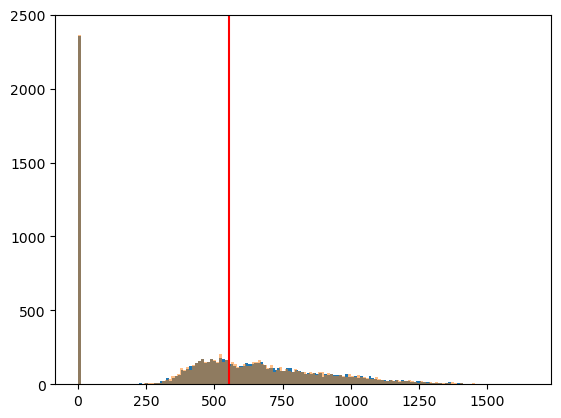

In [207]:
import matplotlib.pyplot as plt
plt.hist(pred,bins=150,alpha=1)
tp = pd.read_csv('./lgb-nw.csv')['Income']
for i in test[(test['Age'] < 15)].index:
    tp[i] = 0
for i in test[(test['Employment_Status'] == 'Not Working')].index:
    tp[i] = 0
for i in test[(test['Industry_Status'] == 'Not in universe or children')].index:
    tp[i] = 0
for i in range(len(pred)):
    if tp[i] < 200:
        tp[i] = 0
#     elif tp[i] > 0 and tp[i] < 200:
#         tp[i] = 200
plt.hist(tp,bins=150,alpha=0.5)
# plt.hist(train['Income'],bins=50)
plt.ylim(0,2500)
plt.vlines(train['Income'].mean(),0,3000,color='red')

In [208]:
train = pd.read_csv('./open/train.csv')
print(train[(train['Income'] > 0) & (train['Income'] < 3000)]['Income'].mean())
print(np.mean([i for i in pred if i > 0]))

937.9085463972823
692.7082751610784


In [209]:
sub = pd.read_csv('./open/sample_submission.csv', index_col=0)
sub['Income'] = pred
sub.to_csv('./lgb.csv')

In [ ]:
# 앙상블해봐바